# **Leather Defect Classification**

In recent years, modern tanning industries have increasingly focused on the production of high-quality leather goods in order to remain competitive in the global market. However, during the different stages of the production process, such as material handling, tanning, and dyeing, numerous surface defects may arise. Among the most common are folding marks, grain off, growth marks, loose grains, and pinhole defects.

Manual inspection of leather surfaces is often subjective, inconsistent, and highly dependent on the operator’s experience. Moreover, many defects exhibit ambiguous patterns and extremely subtle characteristics, sometimes difficult to distinguish with the naked eye. For this reason, machine vision systems now represent a strategic solution for automating quality control, ensuring greater objectivity, repeatability, and efficiency.

# **Project Goals**

The primary objective of this project is to design, implement, and compare two different deep learning approaches for the multiclass classification of leather surface defects.

# **Dataset Description**

Leather Defect Classification Dataset: https://www.kaggle.com/datasets/praveen2084/leather-defect-classification



Before starting our analysis we import the dataset from our drive.

In [ ]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

# 2. Identify who is running the notebook and set the working directory
if os.path.exists(path_MG):
    working_dir = path_MG
    print(f"Working in MG folder: {working_dir}")
elif os.path.exists(path_LM):
    working_dir = path_LM
    print(f"Working in LM folder: {working_dir}")
else:
    print("Error: Project folder not found in Drive. Check the paths.")
    working_dir = None

# 3. Fast Data Extraction Setup
if working_dir:
    os.chdir(working_dir) # Move into the correct Drive folder
    zip_filename = 'leather-defect-classification.zip'
    fast_local_dir = '/content/fast_dataset'

    # Check if the ZIP is safely stored in the Drive folder
    if os.path.exists(zip_filename):
        print(f"Great! {zip_filename} found on Drive.")

        # Extract it to Colab's fast SSD (only if not already done in this session)
        if not os.path.exists(fast_local_dir):
            print("Creating fast local directory and extracting data...")
            os.makedirs(fast_local_dir, exist_ok=True)
            # Unzip quietly (-q) to the fast disk
            !unzip -q {zip_filename} -d {fast_local_dir}
        else:
            print("Fast dataset already exists in this Colab session!")
    else:
        print(f"Error: {zip_filename} not found. Please run the Data Loading notebook first.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working in MG folder: /content/drive/MyDrive/00gerem00/DL-AI-Project
Great! leather-defect-classification.zip found on Drive.
Fast dataset already exists in this Colab session!


In [ ]:
from torchvision.datasets import ImageFolder

# 1. Point base_dir to the fast local directory we created in the previous cell
base_dir = '/content/fast_dataset'

# 2. Automatically find the subfolder containing the classes
content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

print(f"Data path identified: {data_dir}")

# 3. Connect PyTorch to the fast directory!
dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")
print(f"Index mapping: {dataset.class_to_idx}")

Data path identified: /content/fast_dataset/Leather Defect Classification
Total number of images: 3600
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


We successfully connected the project to the image library, identifying a total of 3,600 images. These images are organized into six distinct categories representing different types of leather quality and defects:

* **Defect Categorie**s: Folding marks, Grain off, Growth marks, Loose grains, and Pinhole.

* **Control Category**: Non-defective (healthy leather).

Before proceeding with the Exploratory Data Analysis, we perform a comprehensive scan of the physical files stored on the fast local disk. The goal is to validate the structural homogeneity of the dataset. These lines of code iterate through every image to extract its pixel dimensions and its color mode.

In [ ]:
from collections import Counter
from PIL import Image

size_counter = Counter()
color_modes = set()

for path, _ in dataset.samples:
    with Image.open(path) as img:
        size_counter[img.size] += 1
        color_modes.add(img.mode)

print("\nSize Report:")
for size, count in size_counter.items():
    print(f" - {size[0]}x{size[1]} pixel: {count} images")

print(f"\nColor Mode: {color_modes}")


Size Report:
 - 227x227 pixel: 3598 images
 - 4608x3288 pixel: 2 images

Color Mode: {'RGB'}


This audit allows us to identify two outlier images with "giant" resolutions that differed from the standard $227 \times 227$ format.

In [ ]:
dataset.samples = [s for s in dataset.samples if Image.open(s[0]).size == (227, 227)]
dataset.imgs = dataset.samples
dataset.targets = [s[1] for s in dataset.samples]
print(f"{len(dataset)} images")

3598 images


Instead of modifying the raw files on Google Drive, which preserves data integrity for future use, we perform an in-memory filtering of the PyTorch dataset object.
* **Dynamic Filtering**: We redefine dataset.samples using a list comprehension that opens each image and validates its dimensions. Only images that are exactly $227 \times 227$ pixels are retained. This effectively drops the 2 giant outliers from the current session.
* **Redundancy Alignment**: In PyTorch, ImageFolder maintains an internal list called imgs which is a legacy duplicate of samples. To ensure full compatibility with all PyTorch utility functions and data loaders, we explicitly synchronize dataset.imgs with our filtered list.
* **Target Alignment**: A common pitfall in PyTorch is that the samples list (file paths) and the targets list (class labels) are stored separately. This cell explicitly re-synchronizes the dataset.targets to match the filtered samples.

By performing this at the object level, we ensure that every subsequent analysis and the training process itself only see the 3598 valid images, providing a clean and consistent input space for our tasks.

# **1. Exploratory Data Analysis**

In this section, we visualize the Class Distribution of the leather dataset by plotting the classes histogram. The purpose of this visualization is to ensure the dataset is balanced.

The final dataset distribution is shown in the figure below. After removing two dimensional outliers, each of the six classes remains almost perfectly balanced, with Folding Marks, Growth Marks, Loose Grains and Non Defective classes containing 600 images, while Grain Off and Pinhole classes containing 599 images.

This minimal difference does not introduce any relevant class imbalance and therefore does not require additional resampling or weighting strategies. The dataset can be considered effectively balanced for training and evaluation purposes.

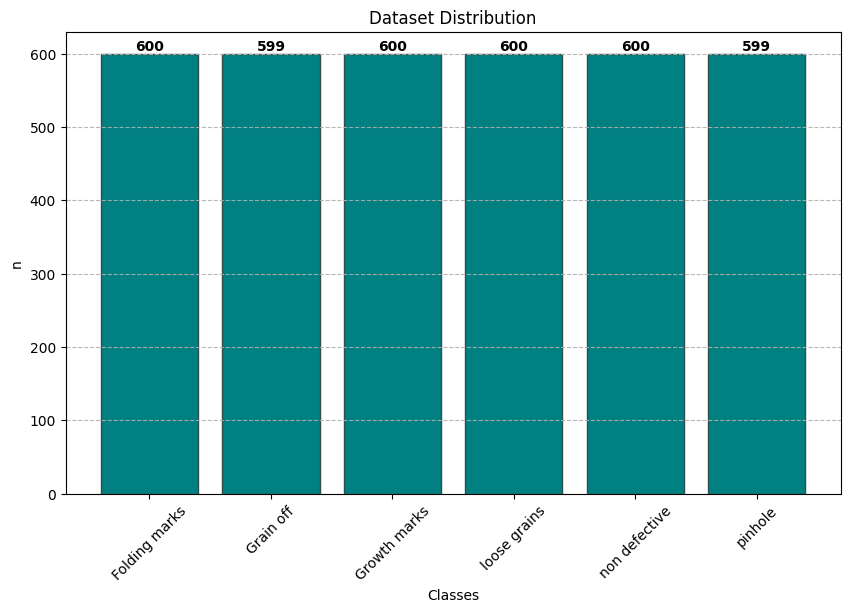

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Estrazione delle etichette (targets) dal dataset
# dataset.targets restituisce una lista di indici (es. [0, 0, 1, 2, ...])
labels = dataset.targets
counts = Counter(labels)

# Mappatura da indice numerico a nome della classe
class_names = dataset.classes
distribution = {class_names[idx]: count for idx, count in counts.items()}

# Generazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.bar(distribution.keys(), distribution.values(), color='teal', edgecolor='darkslategrey')
plt.xlabel('Classes')
plt.ylabel('n')
plt.title('Dataset Distribution')
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.9)

for i, v in enumerate(distribution.values()):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.show()

Then we perform a Visual Inspection of the dataset. While the previous steps focused on hidden data like file sizes and class counts, this step is about looking at the actual content of the dataset.
The goal of this visualization is to get a first-hand look at the leather samples to understand the complexity of the task. By selecting images at random, we get an unbiased view of the data.

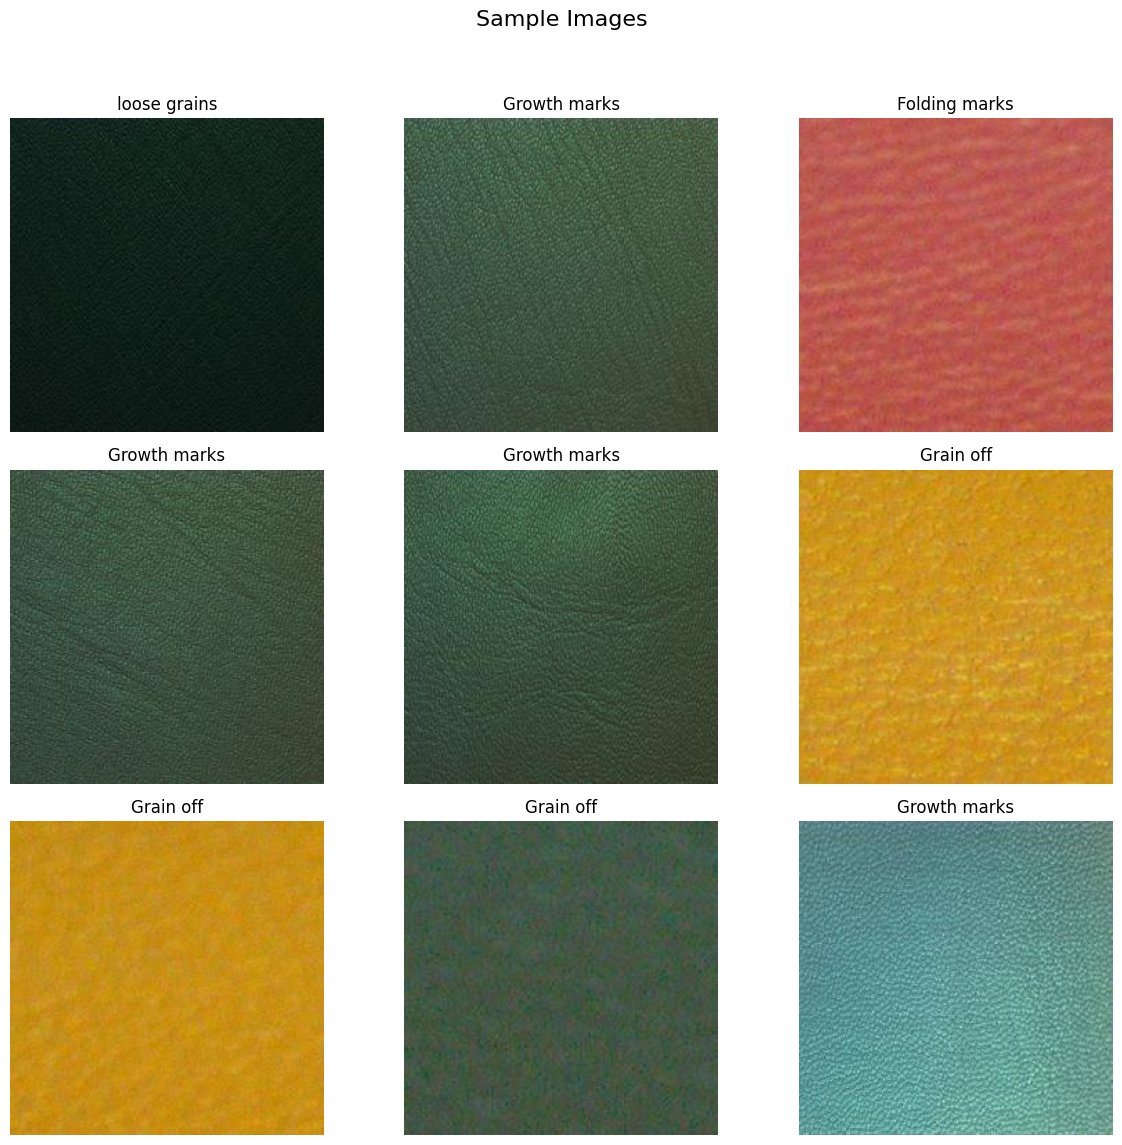

In [ ]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(9):
    idx = random.randint(0, len(dataset) - 1)

    img, label = dataset[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)


    plt.title(dataset.classes[label])
    plt.axis("off")

plt.suptitle("Sample Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The output allows us to confirm that the labels actually match what is visible in the image and to assess the variety within each class, specifying that color differences are not consistently associated with specific defect categories.

The figure shows randomly selected sample images from the dataset. A visual inspection indicates that the classification problem is primarily texture-based. The different classes exhibit subtle variations in surface patterns and structural irregularities, while color differences are not consistently associated with specific defect categories.